# Localization with a known map  - Tutorial: Part 2

Localization with a known map, where the map is given as family of line segments. Moreover we optionally allow the environment to be clutterd with additional boxes, which are not mapped. We refer to such a map as _idealized_.



In [1]:
# This is a fix for vscode, because it doesn't like my
# julia docstrings for whatever reason, and throws a `Katex` error.
using Markdown
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = plain(io, md)

In [2]:
include("src/localization_part_1.jl")

Loading `../data/data_4.jld2` ...

	_segs      Vector{Segment}
	_boxes     Vector{Segment}
	_center    Vector{Float64}
	_xs        Vector{Vector{Float64}}
	_hds       Vector{Float64}
	_ps        Vector{Pose}
	_dxs       Vector{Vector{Float64}}
	_dhds      Vector{Float64}
	_us        Vector{Control}
	_T         Int64
_segs_   CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}
_boxes_  CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}
_ps_     CuArray{Float64, 2, CUDA.Mem.DeviceBuffer}
_as_     CuArray{Float64, 1, CUDA.Mem.DeviceBuffer}

_fov     Float64
_as      Vector{Float64}
_zs      Vector{Vector{Float64}}
_ys      Vector{Vector{Vector{Float64}}}


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any, Any, Any, Any], true, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing, Some(100.0)], var"##sensor_model#395", Bool[0, 0, 0, 0, 0, 0, 0], false)

In [ ]:
#nbx --fname="src/localization_part_2.jl"
using GenParticleFilters

In [136]:
#nbx
function perturb(u::Control, x_noise, hd_noise)
    dx  = u.dx  + diagnormal([0.,0.], [x_noise, x_noise])
    dhd = u.dhd + normal(0, hd_noise)
    return Control(dx,dhd)
end

perturb (generic function with 1 method)

Create noisy controls, run the cell below till you are happy with the amount of noise.

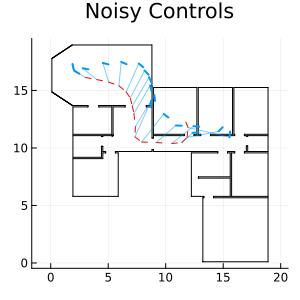

In [40]:
x_noise  = 0.5
hd_noise = 5/360*2π
us_noisy = perturb.(_us, x_noise, hd_noise);

rel_ps = [p+u for (p,u) in zip(_ps[1:end-1],us_noisy)];
ps = [_ps[1]]
for u in us_noisy
    push!(ps, ps[end] + u)
end
# ---------------------
myplot = plot(size=(300,300), 
    title="Noisy Controls",
    aspect_ratio=1., legend=nothing)
plot!(_segs, c=:black)
plot!(_ps[1], c=:red)
plot!(_ps, c=:red)
for (p,q) in zip(_ps[2:end],ps)
    plot!(q, c=col[1], linewidth=2)
    plot!([p.x,q.x], c=col[1], alpha=0.5)
end
myplot

```julia

    prior     chain 
     0          1        2          t-1

               u[1] --- u[2]  ...  u[t-1]
                |        |          |
    p[1] - - - p[2] --- p[3]  ...  p[t]
     |          |        |          |
    y[1]       y[2]     y[3]  ...  y[t] 
     |          |        |          |
     m          m        m          m
```

In [100]:
#nbx
@gen function slam_kernel(t, state, m, us, x_noise, hd_noise, w, s_noise, outlier, outliver_vol)
    
    p,_ = state
    u = us[t]

    p  = {:pose}   ~ motion_model(p, u, x_noise, hd_noise)
    x  = {:sensor} ~ sensor_model(p, m, w, s_noise, outlier, outliver_vol)
    
    state = (p, x)
return state
end

slam_chain = Gen.Unfold(slam_kernel)
Gen.@load_generated_functions

In [106]:
#nbx
@gen (static) function static_slam_model(T, 
        m,
        us, 
        p0, x0_noise, hd0_noise,  
        x_noise, hd_noise, 
        w, s_noise, outlier, outliver_vol)
    
    # Start the Markov chain; 
    # No motion, just the prior
    p  = { :pose   } ~ pose_prior_model(p0, x0_noise, hd0_noise)
    x  = { :sensor } ~ sensor_model(p, m, w, s_noise, outlier, outliver_vol) # GPU accelerated
    
    # Unfold the MArkov chain
    chain ~ slam_chain(T, (p, nothing), m, us, 
        x_noise, hd_noise, 
        w, s_noise, outlier, outliver_vol)
    
    return [(p,x);chain]
end

Gen.@load_generated_functions

In [137]:
#nbx
add_addr_prefix(t, addr) = t==0 ? addr : :chain => t => addr

add_addr_prefix (generic function with 1 method)

In [138]:
#nbx
function constraints(t::Int, _zs, _as)
    ch = choicemap()
    # if t==0
    #     addr  = :sensor => :x
    # else
    #     addr  = :chain => t => :sensor => :x
    # end
    n = length(_zs[t+1])
    x = polar_inv(_zs[t+1],_as)
    ch[add_addr_prefix(t, :sensor => :x)] = x
    return ch
end

constraints (generic function with 1 method)

In [120]:
#nbx
get_pose(tr,t)     = tr[][t][1]
get_last_pose(tr)  = tr[][end][1]
get_first_pose(tr) = get_pose(tr,1)
get_obs(tr,t)      = tr[][t][2]
get_first_obs(tr)  = get_obs(tr,1)

get_first_obs (generic function with 1 method)

In [121]:
#nbx
function plot_slam_trace!(tr; show_obs=true)
    T,m, = get_args(tr)
    ps = get_pose.([tr],1:T+1)
    xs = get_obs.([tr],1:T+1)

    myplot = plot(size=(300,300), 
        title="A Trace",
        aspect_ratio=1., legend=nothing)
        
    plot!(_ps, c=:red)
    plot!(ps, c=col[1])
    plot!(_segs,  c=:black)
    plot!(_boxes, c=:magenta)
    if show_obs
        for (x,p) in zip(xs, ps)
            myplot = scatter!(x .* p, c=col[1], markersize=2)
        end
    end
    return myplot
end

plot_slam_trace! (generic function with 2 methods)

In [122]:
idealized = true
the_map   = idealized ? _segs : vcat(_segs, _boxes);

p0        = _ps[1]
x0_noise  = .2
hd0_noise = 10/360*2π

x_noise  = 0.25
hd_noise = 10/360*2π

filter_size = 10
s_noise     = 0.1
outlier     = 0.0
outlier_vol = 1.0

args = (
    the_map,                           # Map
    us_noisy,                          # Controls
    p0, x0_noise, hd0_noise,           # Pose prior model
    x_noise, hd_noise,                 # Motion model
    filter_size, s_noise, outlier, outlier_vol   # Sensor model
);

T = 1
tr = simulate(static_slam_model, (T, args...))
get_choices(tr)

│
├── :pose
│   │
│   ├── :hd : -1.422730847557926
│   │
│   └── :x : [1.8226586091172923, 16.931235276105415]
│
├── :sensor
│   │
│   └── :x : [[-1.8406888715224832, 0.035156121625621754], [-1.7269258098723612, -0.4095336425706054], [-1.6653535674768827, -0.09703895390479189], [-1.8053636298149363, 0.1752256287203838], [-1.8611864401596332, 0.03439284001485429], [-1.5449203365595416, -0.2801011914918924], [-1.6288941724692427, -0.6258025185349613], [-1.8029947775193838, -0.2634440701714482], [-1.7485410247868816, 0.030236684168050268], [-1.6575924922463836, -0.3693986691524322], [-1.611819473176076, -0.4283793155872242], [-1.6620555598916116, -0.2841919978156319], [-1.703766127640106, -0.16237483518112278], [-1.515883878405169, -0.4978415548678839], [-1.74949279408105, -0.5353967921066665], [-1.6309414732499583, -0.5392809361822438], [-1.6459721716646614, -0.30565546654482056], [-1.5119811255179452, -0.7538183435289882], [-1.6563613427949115, -0.8315283724131521], [-1.6259389075643509

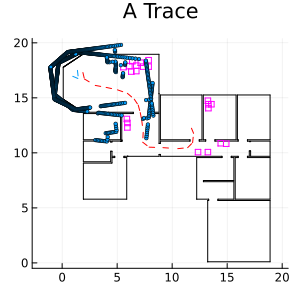

In [123]:
ch = merge([constraints(t,_zs,_as) for t=0:T]...);
tr,w = generate(static_slam_model, (T, args...), ch)
plot_slam_trace!(tr)

In [14]:
argdiffs(bs::Array{T,1}) where T <: Real = Tuple(map(b -> Bool(b) ? UnknownChange() : NoChange(), bs));
argdiffs([0,0.0,1.0, 1])

(NoChange(), NoChange(), UnknownChange(), UnknownChange())

PF Default

In [134]:
N = 100 # 1_000 works decent

idealized = true
the_map   = idealized ? _segs : vcat(_segs, _boxes);

p0 = _ps[1]
x0_noise  = .4
hd0_noise = 12/360*2π

x_noise  = 0.5
hd_noise = 20/360*2π

wind    = 10
s_noise = 0.1
outlier = 1e-2
outlier_vol = 1e2

args = (
    the_map,                               # Map
    us_noisy,                              # Controls
    p0, x0_noise, hd0_noise,               # Pose prior model
    x_noise, hd_noise,                     # Motion model
    wind, s_noise, outlier, outlier_vol    # Sensor model
);

# Initialize the PF
ch    = constraints(0,_zs,_as);
# state = initialize_particle_filter(static_slam_model, (0, args...), ch, N);
state = pf_initialize(static_slam_model, (0, args...), ch, N);

# (Approximately) "ensure"  that the 
# initial particles are samples from the posterior
# r = maybe_resample!(state)

# println("$(r), $(length(Set(state.parents)))")

diffs = argdiffs([1; zeros(length(args))])
times = []
for t=1:_T-1

    resample = effective_sample_size(state) < 0.2*N
    if resample
        # Perform residual resampling, pruning low-weight particles
        pf_resample!(state, :residual)
    end

    ch = constraints(t,_zs,_as);    
    sec = @elapsed pf_update!(state, (t, args...), diffs, ch)
    
    # sec = @elapsed dw, = particle_filter_step!(state, (t, args...), diffs, ch)
    # r = maybe_resample!(state; ess_threshold=N)
    
    ms = sec*1_000
    push!(times, ms)
    println("$(resample), $(length(Set(state.parents))) ($(nice_f(ms)) ms)")
end

true, 1 (94.57 ms)
true, 1 (100.76 ms)
true, 1 (99.00 ms)
true, 1 (98.26 ms)
true, 1 (94.32 ms)
true, 1 (93.88 ms)
true, 1 (96.45 ms)
true, 1 (97.04 ms)
true, 1 (237.41 ms)
true, 1 (92.49 ms)
true, 1 (94.76 ms)
true, 1 (96.85 ms)
true, 1 (96.03 ms)
true, 1 (99.05 ms)
true, 1 (100.71 ms)
true, 1 (102.62 ms)
true, 1 (97.08 ms)


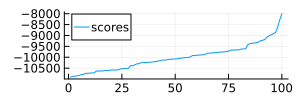

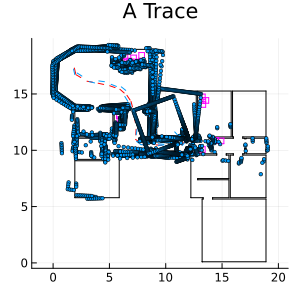

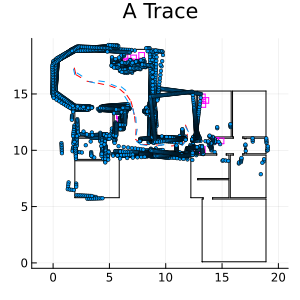

In [135]:
trs    = state.traces
ws     = state.log_weights
scores = get_score.(trs)

perm = sortperm(scores)

trs    = trs[perm]
ws     = ws[perm]
scores = scores[perm]

display(plot(scores, size=(300,100), label="scores"))

display(plot_slam_trace!(trs[1]))
display(plot_slam_trace!(trs[end]))

PF - Default with drift

In [75]:
:x in [:x,:hd]

false

In [124]:
@gen function pose_drift_proposal(tr, x_noise, hd_noise, vars=[:x,:hd])
    
    T, = get_args(tr)
    p  = get_pose(tr,T+1)

    if :x in vars 
        x  = {add_addr_prefix(T, :pose => :x)}  ~ diagnormal(p.x, [x_noise, x_noise])
    end

    if :hd in vars 
        hd = {add_addr_prefix(T, :pose => :hd)} ~ normal(p.hd, hd_noise)
    end
    
    tr
end;

In [131]:
# Number of particles 
# and drifts
N = 10
D = 100

idealized = true
the_map   = idealized ? _segs : vcat(_segs, _boxes);

p0 = _ps[1]
x0_noise  = .4
hd0_noise = 12/360*2π

x_noise  = 0.5
hd_noise = 20/360*2π

wind = 10
s_noise = 0.1
outlier = 1e-2
outlier_vol = 1e2

args = (
    the_map,                               # Map
    us_noisy,                              # Controls
    p0, x0_noise, hd0_noise,               # Pose prior model
    x_noise, hd_noise,                     # Motion model
    wind, s_noise, outlier, outlier_vol    # Sensor model
);

# Initialize the PF
ch    = constraints(0,_zs,_as);
# state = initialize_particle_filter(static_slam_model, (0, args...), ch, N);
state = pf_initialize(static_slam_model, (0, args...), ch, N);

# (Approximately) "ensure"  that the 
# initial particles are samples from the posterior
# r = maybe_resample!(state)

# println("$(r), $(length(Set(state.parents)))")

diffs = argdiffs([1; zeros(length(args))])
times = []
for t=1:_T-1

    scores = get_score.(state.traces)
    sec = @elapsed pf_rejuvenate!(state, mh, (pose_drift_proposal, (0.1, 2/180*π, [:x, :hd])), D)
    diff_scores = get_score.(state.traces) - scores
    println(minimum(diff_scores), " " , maximum(diff_scores))

    resample = effective_sample_size(state) < 0.2*N
    if resample
        # Perform residual resampling, pruning low-weight particles
        pf_resample!(state, :residual)
    end

    ch = constraints(t,_zs,_as);    
    sec += @elapsed pf_update!(state, (t, args...), diffs, ch)


    
    # sec = @elapsed dw, = particle_filter_step!(state, (t, args...), diffs, ch)
    # r = maybe_resample!(state; ess_threshold=N)
    
    ms = sec*1_000
    push!(times, ms)
    println("$(resample), $(length(Set(state.parents))) ($(nice_f(ms)) ms)")
end

763.6667892949697 2940.3317684539393
true, 1 (1138.79 ms)
242.70044158133044 2923.1360673363624
true, 1 (1045.26 ms)
106.25397786624535 2898.262257876672
true, 1 (1191.92 ms)
627.9516435590626 2932.8986605810987
true, 1 (1218.00 ms)
902.1852009315237 2346.5950412496895
true, 1 (1196.24 ms)
1181.6281228888777 2795.796162830953
true, 1 (1205.83 ms)
970.6936763547133 2633.137116385401
true, 1 (1017.57 ms)
171.19370443073876 2881.4913529430273
true, 1 (1177.72 ms)
81.44487486618141 2756.7495876453468
true, 1 (1233.99 ms)
1201.285815951245 2396.719798480328
true, 1 (1211.19 ms)
690.9293063134678 2840.392421500623
true, 1 (1218.73 ms)
358.89555671328526 2837.695960362318
true, 1 (1070.64 ms)
854.8704992124171 3087.858326006364
true, 1 (1215.97 ms)
1194.4690300019429 3362.6770299793106
true, 1 (1223.06 ms)
546.4100599070034 2966.767395275892
true, 1 (1281.20 ms)
652.1926017686678 2656.5818367716683
true, 1 (1093.49 ms)
276.1194861777303 2439.9176324055215
true, 1 (1251.00 ms)


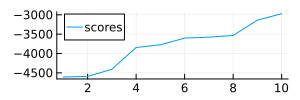

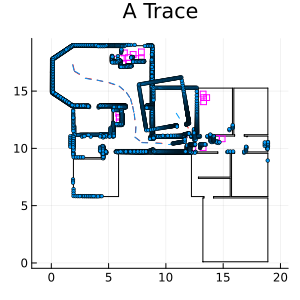

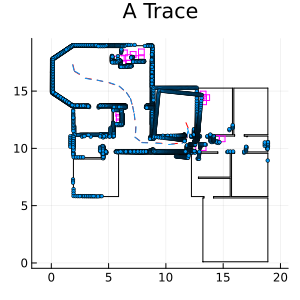

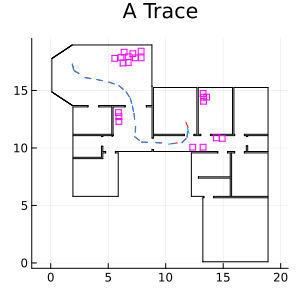

In [133]:
trs    = state.traces
ws     = state.log_weights
scores = get_score.(trs)

perm = sortperm(scores)

trs    = trs[perm]
ws     = ws[perm]
scores = scores[perm]

display(plot(scores, size=(300,100), label="scores"))
display(plot_slam_trace!(trs[1]))
display(plot_slam_trace!(trs[end], show_obs=true))
display(plot_slam_trace!(trs[end], show_obs=false))

PF - grid proposal